<a href="https://www.kaggle.com/code/laraibakhtar/lab-12?scriptVersionId=178148175" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import keras
from keras.layers import Dense,Input, InputLayer, Flatten
from keras.models import Sequential, Model, load_model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,f1_score


2024-05-17 07:07:32.542008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 07:07:32.542106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 07:07:32.665824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


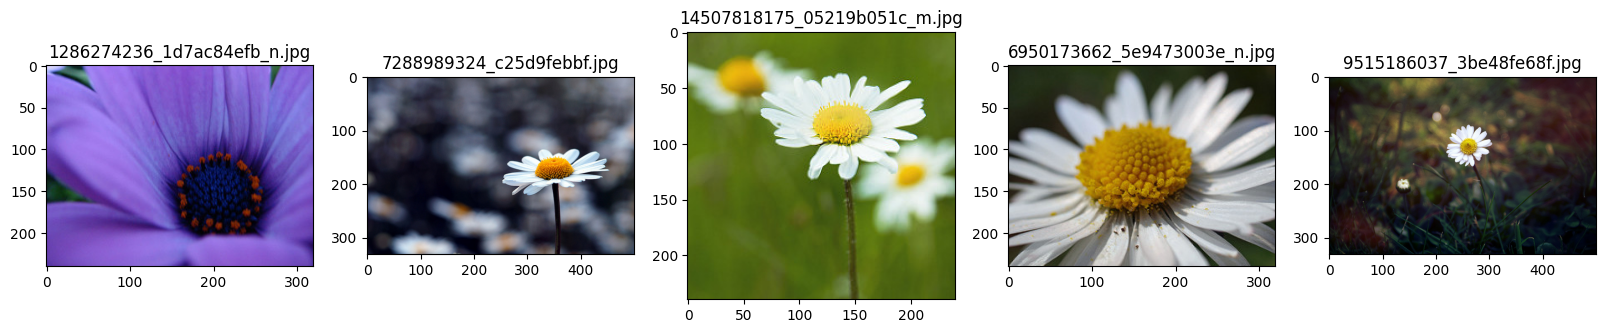

In [2]:
#View some samples of the dataset
import random
plt.figure(figsize=(20,20))
folder=r'/kaggle/input/flowers-recognition/flowers/daisy'
for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path= os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)


In [3]:
def load_and_preprocess_data(data_dir, image_size):
    images = []
    labels = []

    # Iterate through each folder (each class of flowers)
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)

        # Iterate through each image in the class folder
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Read image and resize
            image = cv2.imread(image_path) #reads in BGR format
            #To read an image in grayscale 
            #image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, image_size)

            # Normalize pixel values to [0, 1]
            image = image.astype('float32') / 255.0

            # Append to the lists
            images.append(image)
            labels.append(class_name)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



In [4]:
dataset_dir = "/kaggle/input/flowers-recognition/flowers"

In [5]:
image_size = (128, 128)

images, labels = load_and_preprocess_data(dataset_dir, image_size)

In [6]:
images

array([[[[0.1764706 , 0.17254902, 0.15294118],
         [0.18039216, 0.18039216, 0.16078432],
         [0.1882353 , 0.19215687, 0.16862746],
         ...,
         [0.20392157, 0.13333334, 0.08627451],
         [0.20392157, 0.13333334, 0.08627451],
         [0.20392157, 0.13333334, 0.08627451]],

        [[0.1764706 , 0.1764706 , 0.15686275],
         [0.18431373, 0.18039216, 0.16470589],
         [0.1882353 , 0.19215687, 0.17254902],
         ...,
         [0.2       , 0.13333334, 0.08627451],
         [0.20392157, 0.13333334, 0.08627451],
         [0.20392157, 0.13725491, 0.09019608]],

        [[0.18039216, 0.1764706 , 0.16078432],
         [0.18431373, 0.1882353 , 0.16862746],
         [0.19215687, 0.19607843, 0.17254902],
         ...,
         [0.2       , 0.13725491, 0.08627451],
         [0.2       , 0.13725491, 0.08627451],
         [0.20784314, 0.14117648, 0.09411765]],

        ...,

        [[0.10588235, 0.19607843, 0.32156864],
         [0.10196079, 0.19215687, 0.3137255 ]

In [7]:
from sklearn.preprocessing import LabelEncoder
# Convert class labels to one-hot encoded vectors
label_encoder = LabelEncoder()
encoded_class_names = label_encoder.fit_transform(labels)

In [8]:
encoded_class_names

array([1, 1, 1, ..., 2, 2, 2])

In [9]:
labels

array(['dandelion', 'dandelion', 'dandelion', ..., 'rose', 'rose', 'rose'],
      dtype='<U9')

In [10]:
from sklearn.model_selection import train_test_split


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_class_names, test_size=0.33, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check the shapes of the datasets
print("Train images shape:", X_train.shape)
print("Train labels shape:", X_test.shape)
print("Validation images shape:", y_train.shape)
print("Validation labels shape:", y_test.shape)


Train images shape: (2892, 128, 128, 3)
Train labels shape: (1425, 128, 128, 3)
Validation images shape: (2892,)
Validation labels shape: (1425,)


In [11]:
y_train

array([1, 1, 4, ..., 4, 2, 1])

In [12]:
model = keras.Sequential([
    keras.layers.Conv2D(128, (3, 3), input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3)),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.GlobalMaxPooling2D(),
    
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.02),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10),
    keras.layers.Activation('softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 126, 126, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,346 (868.54 KB)

 Trainable params: 222,346 (868.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
initial_lr = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
 6/73 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1227 - loss: 2.1673

I0000 00:00:1715929722.649531      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.2507 - loss: 1.6910 - val_accuracy: 0.4819 - val_loss: 1.2668
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4725 - loss: 1.1986 - val_accuracy: 0.5250 - val_loss: 1.1561
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5750 - loss: 1.0183 - val_accuracy: 0.5976 - val_loss: 1.0532
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6247 - loss: 0.9409 - val_accuracy: 0.6615 - val_loss: 0.9464
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6802 - loss: 0.8411 - val_accuracy: 0.6632 - val_loss: 0.9075
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6610 - loss: 0.8229 - val_accuracy: 0.6753 - val_loss: 0.8843
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7049 - loss: 0.7823 - val_accuracy: 0.6615 - val_loss: 0.8592
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7210 - loss: 0.7392 - val_accuracy: 0.6995 - val_loss: 

In [15]:
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
#predicted_class_names = label_encoder.inverse_transform(predicted_labels)

f1 = f1_score(y_test, predicted_labels, average='macro')
report = classification_report(y_test, predicted_labels)

print("F1 Score:", f1)
print("Classification Report:")
print(report)

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
F1 Score: 0.779158433465659
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       268
           1       0.88      0.77      0.82       361
           2       0.67      0.64      0.65       253
           3       0.77      0.88      0.82       239
           4       0.72      0.80      0.76       304

    accuracy                           0.78      1425
   macro avg       0.78      0.78      0.78      1425
weighted avg       0.79      0.78      0.78      1425

